In [83]:
%matplotlib inline 

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import copy
import ast
from collections import defaultdict
from datetime import datetime, timedelta
import pickle
from scipy import stats

from sklearn.decomposition import PCA
from sklearn.metrics import mean_squared_error, r2_score

from keras.models import load_model


## Data Import and Preprocessing

In [42]:
# import the price data
prices_df = pd.read_csv(
    '../Data/ds_spx_1990-2020_survivorship_free_prices.csv',
    index_col = 0,
    parse_dates = True,
    ).dropna(axis=1, how='all').astype('float32')

# import S&P index price
spx_df = pd.read_csv(
    '../Data/ds_spx_1973-2020_index.csv',
    index_col = 0,
    parse_dates = True,
    ).dropna(axis=1, how='all').astype('float32')

# import the mapping table 
map_df = pd.read_csv(
    '../Data/eikon_map_table.csv', 
    index_col = 0
    )

# import the index constituents data
constituents_df = pd.read_csv(
    '../Data/eikon_spx_constituents_1995.csv', 
    index_col = 0, 
    parse_dates = True
    )
constituents_df['Index Constituents'] = constituents_df['Index Constituents'].apply(ast.literal_eval)

In [43]:
# create a monthly date range 
dates = pd.date_range('2010-01', '2020-01', freq = 'BM').strftime('%Y-%m')

# resample price data to weekly intervals starting in 2005
prices_df = prices_df.loc['2010-01-01':, :]
spx_df = spx_df.loc['2010-01-01':, :]

# create returns dataframes
returns_df = prices_df.pct_change()
returns_df.iloc[0, :] = 0
spx_returns_df = spx_df.pct_change().fillna(0)

# convert values to NaNs for any time periods where a company is not  a
# constituent of the S&P 500 
for month in dates: 
    constituents = constituents_df.loc[month, 'Index Constituents'].values[0]
    constituents = map_df.loc[constituents, 'ISIN'].values
    not_in_index = [company for company in prices_df[month].columns if company not in constituents]
    prices_df.loc[month, not_in_index] = np.nan
    returns_df.loc[month, not_in_index] = np.nan
    
# for use in the autoencoder, remove any companies that have NaN values
returns_df.dropna(axis = 1, how = 'any', inplace = True)

In [44]:
# split the data into training and test data
train_start_date = '2010-01-01'
train_end_date = '2014-12-31'
test_start_date = '2015-01-01'
test_end_date = '2019-12-31'

train_prices_df = prices_df[train_start_date:train_end_date]
test_prices_df = prices_df[test_start_date:test_end_date]

train_returns_df = returns_df[train_start_date:train_end_date]
test_returns_df = returns_df[test_start_date:test_end_date]

train_spx_df = spx_df[train_start_date:train_end_date]
test_spx_df = spx_df[test_start_date: test_end_date]

train_spx_returns_df = spx_returns_df[train_start_date: train_end_date]
test_spx_returns_df = spx_returns_df[test_start_date: test_end_date]

In [45]:
# quick check for NaN values
n_nan = 0
for df in [train_returns_df, test_returns_df, train_spx_returns_df, test_spx_returns_df]:
    n_nan += df.isna().sum().values.sum()
    if n_nan > 0: 
        print(n_nan, ' NaN values exist')

# Projection onto Principal Components

In [46]:
train_returns_df.head()

,US17275R1023,US3021301094,US6687711084,US4062161017,US4592001014,US2692464017,US38141G1040,BMG491BT1088,US4448591028,US5717481023,...,US4878361082,US9581021055,US8760301072,US6668071029,US50540R4092,US3647601083,US92553P2011,US9621661043,US7237871071,US7081601061
Code,,,,,,,,,,,,,,,,,,,,,
2010-01-01,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2010-01-04,0.031328,0.008916,0.028502,0.038551,0.011841,0.045455,0.025113,-0.006386,0.040784,-0.009511,...,-0.006955,0.025141,-0.006022,0.017905,0.020444,-0.019570,0.008409,0.026428,0.058335,0.020669
2010-01-05,-0.004455,0.006841,-0.005437,0.012800,-0.012080,-0.021739,0.017680,0.005570,-0.000438,-0.024234,...,0.002271,0.026513,0.012118,0.001759,-0.012178,0.012171,0.002001,0.021228,0.000392,0.000736
2010-01-06,-0.006509,-0.023216,0.003282,0.023697,-0.006496,-0.005556,-0.010673,-0.020878,0.007008,0.030459,...,0.000189,0.000861,0.019592,0.003863,-0.016569,0.012025,-0.004993,-0.011055,0.017451,0.016188
2010-01-07,0.004505,-0.006087,-0.002178,0.002469,-0.003462,0.005587,0.019568,0.003046,0.046542,0.012733,...,0.009819,-0.019570,0.000534,0.010319,-0.000270,-0.036597,0.010371,-0.004475,0.008865,-0.029327


In [70]:
# calculate the first 5 PCs (Eigenvectors & Eigenvalues of the covariance matrix)
pca_model = PCA(n_components = 5, copy = True, whiten = False)
pca_model.fit(train_returns_df)

# project the dataset onto the principal components
pca_df = pd.DataFrame(
    pca_model.transform(train_returns_df), 
    index = train_returns_df.index
)

# transform the projections back into the input space
pca_recon_df = pd.DataFrame(
    pca_model.inverse_transform(pca_df), 
    index = train_returns_df.index, 
    columns = train_returns_df.columns
)

In [71]:
pca_df.head()

,0,1,2,3,4
Code,,,,,
2010-01-01,0.011579,0.000093,-0.003192,-0.000837,0.000938
2010-01-04,-0.262266,-0.026856,-0.101162,-0.044687,-0.006820
2010-01-05,-0.085108,0.050598,-0.096073,0.043785,0.056693
2010-01-06,-0.046510,0.021429,-0.068638,-0.053596,0.049246
2010-01-07,-0.144207,0.163237,-0.070393,0.072953,0.123921


In [72]:
pca_recon_df.head() # equivalent to the reconstruct_df for the autoencoder model

,US17275R1023,US3021301094,US6687711084,US4062161017,US4592001014,US2692464017,US38141G1040,BMG491BT1088,US4448591028,US5717481023,...,US4878361082,US9581021055,US8760301072,US6668071029,US50540R4092,US3647601083,US92553P2011,US9621661043,US7237871071,US7081601061
Code,,,,,,,,,,,,,,,,,,,,,
2010-01-01,-0.000405,-0.000418,-0.000328,0.000121,-0.000308,-0.000260,-0.000176,-0.000387,0.000387,0.000196,...,-0.000256,0.000231,-0.000715,0.000219,-0.000184,-0.000066,0.000073,-0.000050,0.000723,-0.001523
2010-01-04,0.012220,0.012712,0.012116,0.044926,0.008311,0.031200,0.023229,0.024516,0.008316,0.010337,...,0.000172,0.021471,0.006955,0.009274,0.006858,0.005306,0.015019,0.014606,0.045002,-0.004477
2010-01-05,0.001559,0.002531,-0.001619,0.007341,-0.002229,0.018647,0.020170,0.010830,-0.002229,0.003618,...,-0.005312,0.005371,0.001216,0.000227,-0.002333,0.005027,0.000935,0.006369,0.007559,0.010097
2010-01-06,-0.002887,-0.000804,-0.005115,0.020355,-0.002103,0.006284,0.008544,0.004530,-0.003066,0.001822,...,-0.003030,0.000424,-0.004495,-0.000878,-0.002212,-0.001376,0.000821,0.005833,0.020915,0.000812
2010-01-07,-0.001266,0.003126,-0.007248,-0.008837,-0.004771,0.021997,0.029903,0.018050,-0.002100,0.009957,...,-0.002439,-0.001490,0.004922,0.003056,-0.002396,0.014522,0.000724,0.015719,-0.007163,0.034963


In [73]:
mse_df = pd.DataFrame()

for co in pca_recon_df.columns:
    mse_df.loc[co, 'error'] = mean_squared_error(train_returns_df[co], pca_recon_df[co])
    mse_df.loc[co, 'name'] = map_df.loc[map_df['ISIN'] == co, 'Company Common Name'].values[0]
    

mse_df.sort_values('error', inplace = True)
mse_df.to_csv('../Data/pca_top_10.csv')
mse_df.head(10)

,error,name
US98389B1008,0.000028,Xcel Energy Inc
US8425871071,0.000030,Southern Co
US2091151041,0.000030,Consolidated Edison Inc
US5404241086,0.000032,Loews Corp
US0530151036,0.000032,Automatic Data Processing Inc
US2333311072,0.000032,DTE Energy Co
US26441C2044,0.000033,Duke Energy Corp
US4781601046,0.000034,Johnson & Johnson
US92939U1060,0.000035,WEC Energy Group Inc
US7234841010,0.000036,Pinnacle West Capital Corp


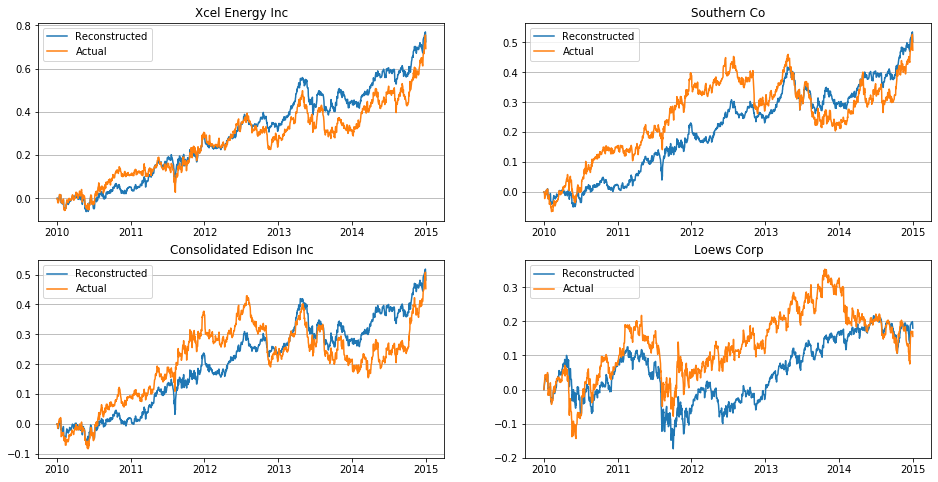

In [74]:
n_top = 4

fig, axs = plt.subplots(nrows = n_top // 2, ncols = 2, figsize=(16, n_top * 2))

for i in range(n_top): 
    isin = mse_df.index[i]
#     isin = mse_df.index[-i+1] # for least representative
    name = mse_df.loc[isin, 'name']
    axs[i//2, i%2].plot(np.cumprod(1 + pca_recon_df[isin]) - 1, label = 'Reconstructed')
    axs[i//2, i%2].plot(np.cumprod(1 + train_returns_df[isin]) - 1, label = 'Actual')
    axs[i//2, i%2].legend(loc = 'best')
    axs[i//2, i%2].grid(axis = 'y')
    axs[i//2, i%2].set_title(name)
plt.show()

### Compare with Autoencoder

In [75]:
ae_model = load_model('model/ae_model_wo_reg_2020_08_27.h5')

ae_recon_df = pd.DataFrame(
    ae_model.predict(train_returns_df),
    columns = train_returns_df.columns, 
    index = train_returns_df.index
)

In [76]:
ae_mse_df = pd.DataFrame()

for co in ae_recon_df.columns:
    mse = mean_squared_error(train_returns_df[co], ae_recon_df[co])
    ae_mse_df.loc[co, 'error'] = mse
    
ae_mse_df.sort_values('error', inplace = True)

In [77]:
for isin in ae_mse_df.index:
    name = map_df.loc[map_df['ISIN'] == isin, 'Company Common Name'].values[0]
    ae_mse_df.loc[isin, 'name'] = name

ae_mse_df.head(10)

,error,name
US98389B1008,0.000028,Xcel Energy Inc
US8425871071,0.000030,Southern Co
US2091151041,0.000031,Consolidated Edison Inc
US5404241086,0.000032,Loews Corp
US2333311072,0.000032,DTE Energy Co
US0530151036,0.000032,Automatic Data Processing Inc
US26441C2044,0.000034,Duke Energy Corp
US4781601046,0.000034,Johnson & Johnson
US92939U1060,0.000035,WEC Energy Group Inc
US7234841010,0.000037,Pinnacle West Capital Corp


### Training Data

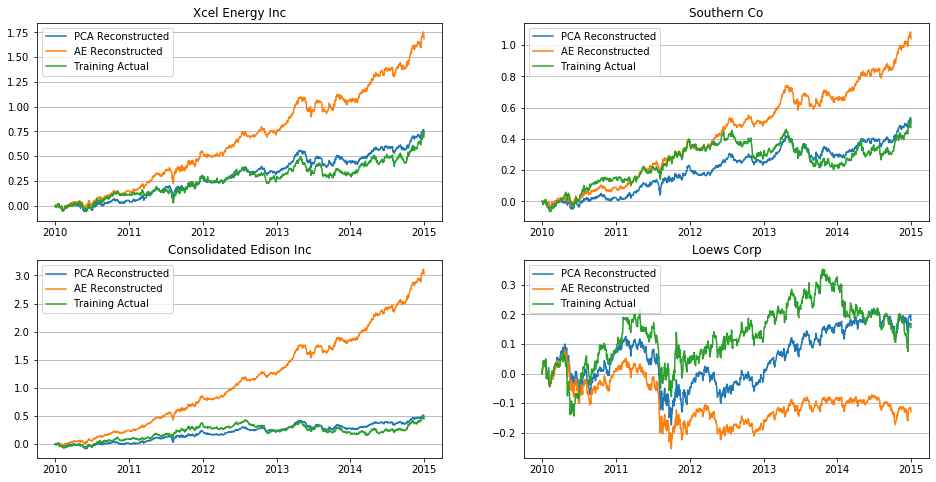

In [78]:
n_top = 4

fig, axs = plt.subplots(nrows = n_top // 2, ncols = 2, figsize=(16, n_top * 2))

for i in range(n_top): 
    isin = mse_df.index[i]
#     isin = mse_df.index[-i+1] # for least representative
    name = mse_df.loc[isin, 'name']
    axs[i//2, i%2].plot(np.cumprod(1 + pca_recon_df[isin]) - 1, label = 'PCA Reconstructed')
    axs[i//2, i%2].plot(np.cumprod(1 + ae_recon_df[isin]) - 1, label = 'AE Reconstructed')
    axs[i//2, i%2].plot(np.cumprod(1 + train_returns_df[isin]) - 1, label = 'Training Actual')
    axs[i//2, i%2].legend(loc = 'best')
    axs[i//2, i%2].grid(axis = 'y')
    axs[i//2, i%2].set_title(name)
plt.show()

### TEST DATA

In [79]:
# project the dataset onto the principal components
test_pca_df = pd.DataFrame(
    pca_model.transform(test_returns_df), 
    index = test_returns_df.index
)

# transform the projections back into the input space
test_pca_recon_df = pd.DataFrame(
    pca_model.inverse_transform(test_pca_df), 
    index = test_returns_df.index, 
    columns = test_returns_df.columns
)

test_mse_df = pd.DataFrame()

for co in test_pca_recon_df.columns:
    test_mse_df.loc[co, 'error'] = mean_squared_error(test_returns_df[co], test_pca_recon_df[co])
    test_mse_df.loc[co, 'name'] = map_df.loc[map_df['ISIN'] == co, 'Company Common Name'].values[0]
    

test_mse_df.sort_values('error', inplace = True)
test_mse_df.head(10)

,error,name
US9029733048,0.000026,U.S. Bancorp
US46625H1005,0.000030,JPMorgan Chase & Co
US6934751057,0.000032,PNC Financial Services Group Inc
US37959E1029,0.000033,Globe Life Inc
US89832Q1094,0.000034,Truist Financial Corp
US98389B1008,0.000034,Xcel Energy Inc
US0255371017,0.000036,American Electric Power Company Inc
US26441C2044,0.000037,Duke Energy Corp
US2333311072,0.000037,DTE Energy Co
US1258961002,0.000037,CMS Energy Corp


In [66]:
ae_recon_df = pd.DataFrame(
    ae_model.predict(test_returns_df),
    columns = test_returns_df.columns, 
    index = test_returns_df.index
)

test_ae_mse_df = pd.DataFrame()

for co in ae_recon_df.columns:
    mse = mean_squared_error(train_returns_df[co], ae_recon_df[co])
    test_ae_mse_df.loc[co, 'error'] = mse
    
test_ae_mse_df.sort_values('error', inplace = True)

for isin in test_ae_mse_df.index:
    name = map_df.loc[map_df['ISIN'] == isin, 'Company Common Name'].values[0]
    test_ae_mse_df.loc[isin, 'name'] = name

test_ae_mse_df.head(10)

,error,name
US5801351017,0.000101,Mcdonald's Corp
US7427181091,0.000103,Procter & Gamble Co
US4781601046,0.000103,Johnson & Johnson
US8425871071,0.000104,Southern Co
US7134481081,0.000104,PepsiCo Inc
US4943681035,0.000111,Kimberly-Clark Corp
US9311421039,0.000111,Walmart Inc
US3703341046,0.000114,General Mills Inc
US4878361082,0.000123,Kellogg Co
US00206R1023,0.000123,AT&T Inc


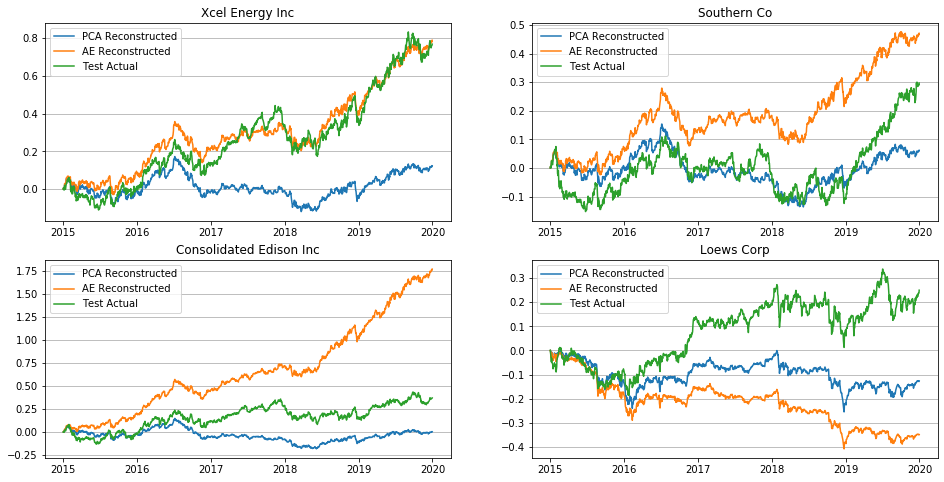

In [67]:
n_top = 4

fig, axs = plt.subplots(nrows = n_top // 2, ncols = 2, figsize=(16, n_top * 2))

for i in range(n_top): 
    isin = mse_df.index[i]
#     isin = mse_df.index[-i+1] # for least representative
    name = mse_df.loc[isin, 'name']
    axs[i//2, i%2].plot(np.cumprod(1 + pca_recon_df[isin]) - 1, label = 'PCA Reconstructed')
    axs[i//2, i%2].plot(np.cumprod(1 + ae_recon_df[isin]) - 1, label = 'AE Reconstructed')
    axs[i//2, i%2].plot(np.cumprod(1 + test_returns_df[isin]) - 1, label = 'Test Actual')
    axs[i//2, i%2].legend(loc = 'best')
    axs[i//2, i%2].grid(axis = 'y')
    axs[i//2, i%2].set_title(name)
plt.show()

In [84]:
evaluation_df = pd.DataFrame()

n_cos = pca_recon_df.shape[1]

for i in range(n_cos): 
    isin = pca_recon_df.columns[i]
    
    train_t_stat, train_p_val = stats.ttest_ind(train_returns_df[isin], pca_recon_df[isin])
    test_t_stat, test_p_val = stats.ttest_ind(test_returns_df[isin], test_pca_recon_df[isin])
    train_r2 = r2_score(train_returns_df[isin], pca_recon_df[isin])
    test_r2 = r2_score(test_returns_df[isin], test_pca_recon_df[isin])
    
    if train_p_val < 0.05:
        train_sig = True
    else:
        train_sig = False
        
    if test_p_val < 0.05:
        test_sig = True
    else:
        test_sig = False
    
    
    evaluation_df.loc[isin, 'name'] = map_df.loc[map_df['ISIN'] == isin, 'Company Common Name'].values[0]
    evaluation_df.loc[isin, 'train_t_stat'] = train_t_stat
    evaluation_df.loc[isin, 'train_p_val'] = train_p_val
    evaluation_df.loc[isin, 'train_sig_5%'] = train_sig
    evaluation_df.loc[isin, 'train_r2'] = train_r2
    evaluation_df.loc[isin, 'test_t_stat'] = test_t_stat
    evaluation_df.loc[isin, 'test_p_val'] = test_p_val
    evaluation_df.loc[isin, 'test_sig_5%'] = test_sig
    evaluation_df.loc[isin, 'test_r2'] = test_r2
    

train_sig = evaluation_df['train_sig_5%'].sum()
test_sig = evaluation_df['test_sig_5%'].sum()

train_sig, test_sig

(0, 6)

In [85]:
1 - (train_sig / n_cos), 1 - (test_sig / n_cos)

(1.0, 0.9815950920245399)

In [86]:
evaluation_df['train_r2'].mean(), evaluation_df['test_r2'].mean()

(0.5294522471438986, 0.4119815841236182)

In [89]:
r2_df = pd.DataFrame()

r2_df.loc['Min', 'Train'] = evaluation_df['train_r2'].min()
r2_df.loc['Max', 'Train'] = evaluation_df['train_r2'].max()
r2_df.loc['Mean', 'Train'] = evaluation_df['train_r2'].mean()
r2_df.loc['Min', 'Test'] = evaluation_df['test_r2'].min()
r2_df.loc['Max', 'Test'] =evaluation_df['test_r2'].max()
r2_df.loc['Mean', 'Test'] =evaluation_df['test_r2'].mean()

r2_df.to_csv('../Data/pca_r2.csv')

r2_df

,Train,Test
Min,0.205191,0.107491
Max,0.781114,0.848155
Mean,0.529452,0.411982


### Evaluate the amount of variance explained by each component

In [14]:
for i, pc in enumerate(pca_model.explained_variance_ratio_):
    print('PC {0}:\t{1:5.2f}%'.format(i + 1, pc * 100.0))

PC 1:	46.06%
PC 2:	 2.17%
PC 3:	 1.99%
PC 4:	 1.81%
PC 5:	 1.49%


### Plot the loading vectors

In [15]:
# pca_model.components_[0]

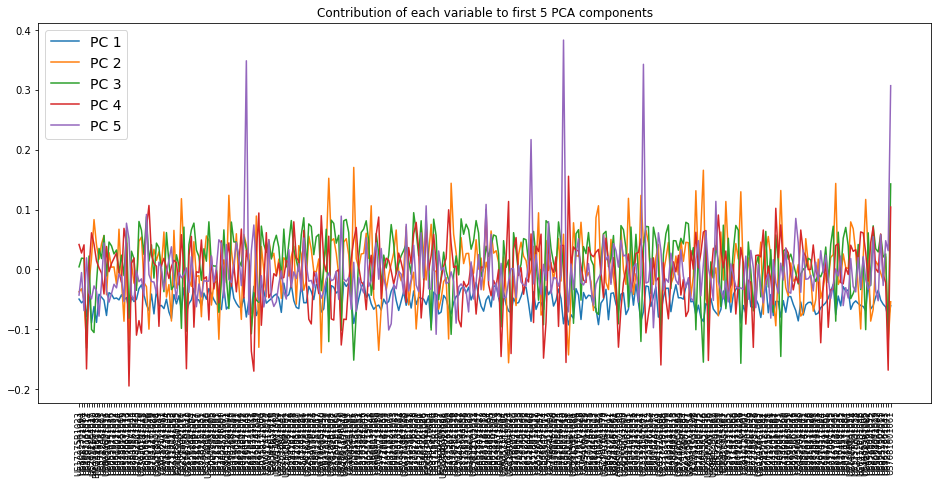

In [16]:
fig = plt.figure(figsize = (16, 7))
plt.title(f'Contribution of each variable to first {pca_model.n_components} PCA components')

plt.plot(np.transpose(pca_model.components_[0]), label = 'PC 1')
plt.plot(np.transpose(pca_model.components_[1]), label = 'PC 2')
plt.plot(np.transpose(pca_model.components_[2]), label = 'PC 3')
plt.plot(np.transpose(pca_model.components_[3]), label = 'PC 4')
plt.plot(np.transpose(pca_model.components_[4]), label = 'PC 5')

plt.xticks(range(len(train_returns_df.columns)), train_returns_df.columns, size = 'small', rotation = 90)

plt.legend(fontsize=14);

Not sure how handy this graph will be for my project. Maybe instead, I can show only the top N companies

### Autoencoder - Extract the left singular vectors of the decoder weight matrix

In [20]:
ae_model = load_model('model/ae_model_wo_reg_2020_08_27.h5')

In [23]:
w1, b1, w2, b2 = ae_model.get_weights()
ae_decoder_lsv, _, _ = np.linalg.svd(w2.T, full_matrices = False)

In [24]:
ae_decoder_lsv.shape # 326 companies

(326, 5)

In [25]:
# plt.plot(ae_decoder_lsv[:50, 0])

In [26]:
# plt.plot(w2.T[:50, 0]) # same shape as above

In [27]:
mu = np.mean(train_returns_df.values, axis=0) # averages per company
ae_lsv_projections = np.array(train_returns_df.values - mu) @ ae_decoder_lsv

In [28]:
ae_df = pd.DataFrame(ae_lsv_projections, index = train_returns_df.index)
ae_df

,0,1,2,3,4
Code,,,,,
2010-01-01,0.011681,0.000018,-0.002560,-0.001393,-0.001036
2010-01-04,-0.249898,-0.101984,-0.031342,-0.070086,-0.056141
2010-01-05,-0.074171,-0.077082,-0.092278,0.049220,-0.044676
2010-01-06,-0.044492,-0.029304,-0.087996,-0.042866,-0.013382
2010-01-07,-0.141859,-0.033633,-0.175130,0.140654,-0.034152
...,...,...,...,...,...
2014-12-25,0.011681,0.000018,-0.002560,-0.001393,-0.001036
2014-12-26,-0.026216,0.034774,0.001020,-0.007462,0.023467
2014-12-29,-0.019622,0.021892,-0.027045,0.003664,0.008683


### Compare the transformed sample covariances

In [29]:
# The sample covariance matrix is given by C.
C = np.dot((train_returns_df - mu).T, train_returns_df - mu)

# The total variance is given by the sum of the diagonal elements of the covariance matrix
# trace is the sum of the diagonal of the matrix
total_variance = np.trace(C)
print('total variance:', total_variance)

total variance: 114.5736


Diagonalize the sample covariance matrix with the m-loading vectors:
$$\text{P}_m^T \text{Y}_0 \text{Y}_0^T \text{P}_m$$

In [30]:
lambda_from_pca = pca_model.components_ @ C @ pca_model.components_.T
lambda_from_pca.shape

(5, 5)

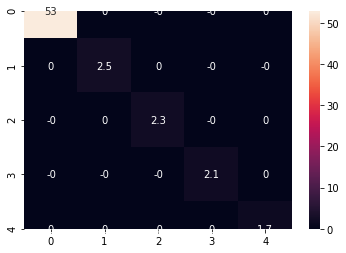

In [31]:
ax = sns.heatmap(lambda_from_pca.round(4), annot=True)

In [32]:
# Show the explained variances by each component (check with above)
print(100 * np.diag(lambda_from_pca) / total_variance)
print('{:.6}% of total variance explained'.format(100 * np.trace(lambda_from_pca) / total_variance)) 

[46.055874   2.1743758  1.9933637  1.806472   1.485008 ]
53.5151% of total variance explained


### Now perform the transformation of the covariance matrix using the decoder weights. 
Note that the matrix $\Lambda$ is no longer diagonal.

In [33]:
lambda_from_decoder_weights = w2 @ C @ w2.T
lambda_from_decoder_weights.shape

(5, 5)

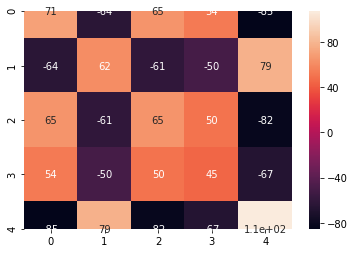

In [34]:
ax = sns.heatmap(lambda_from_decoder_weights.round(4), annot = True)
plt.show()

Finally, perform the transformation of the covariance matrix using the left singular vectors of the decoder weights. The covariance matrix is not diagonalized, but the proportion of the variance explained by each sorted diagonal element is similar to values obtained by PCA.

In [35]:
lambda_from_decoder_lsv = ae_decoder_lsv.T @ C @ ae_decoder_lsv
lambda_from_decoder_lsv.shape

(5, 5)

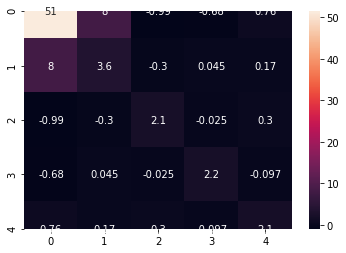

In [36]:
ax = sns.heatmap(lambda_from_decoder_lsv.round(4), annot=True)
plt.show()

In [37]:
print(100 * np.diag(lambda_from_decoder_lsv) / total_variance)
print('{:.6}% of total variance explained'.format(100 * np.trace(lambda_from_decoder_lsv) / total_variance))

[44.869217   3.1418338  1.8268945  1.8830645  1.7913291]
53.5123% of total variance explained


Maybe the total explained variance is so low because the autoencoder uses nonlinear activation functions